In [64]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler


In [65]:
import random

def set_seed(seed):
    random.seed(seed)  # Set the seed for Python's random module
    np.random.seed(seed)  # Set the seed for NumPy
    torch.manual_seed(seed)  # Set the seed for PyTorch
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # Set the seed for CUDA
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
        # Enable deterministic behavior
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(4)

In [66]:
# load 6 modalites data 
from sklearn.utils import resample
import numpy as np
import pandas as pd

def load_data():
    cln_data = pd.read_csv('data/raw_features_cln.csv')
    cnv_data = pd.read_csv('data/raw_features_cnv.csv')
    dna_data = pd.read_csv('data/raw_features_dna.csv')
    mir_data = pd.read_csv('data/raw_features_mir.csv')
    mrna_data = pd.read_csv('data/raw_features_mrna.csv')
    wsi_data = pd.read_csv('data/raw_features_wsi.csv')

    # keep data where all modalities are present based on patient id
    patient_ids = set(cln_data['submitter_id.samples'])
    patient_ids = patient_ids.intersection(set(cnv_data['submitter_id.samples']))
    patient_ids = patient_ids.intersection(set(dna_data['submitter_id.samples']))
    patient_ids = patient_ids.intersection(set(mir_data['submitter_id.samples']))
    patient_ids = patient_ids.intersection(set(mrna_data['submitter_id.samples']))
    patient_ids = patient_ids.intersection(set(wsi_data['submitter_id.samples']))

    cln_data = cln_data[cln_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    cnv_data = cnv_data[cnv_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    dna_data = dna_data[dna_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    mir_data = mir_data[mir_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    mrna_data = mrna_data[mrna_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    wsi_data = wsi_data[wsi_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)

    # sort data by patient id
    cln_data = cln_data.sort_values('submitter_id.samples').reset_index(drop=True)
    cnv_data = cnv_data.sort_values('submitter_id.samples').reset_index(drop=True)
    dna_data = dna_data.sort_values('submitter_id.samples').reset_index(drop=True)
    mir_data = mir_data.sort_values('submitter_id.samples').reset_index(drop=True)
    mrna_data = mrna_data.sort_values('submitter_id.samples').reset_index(drop=True)
    wsi_data = wsi_data.sort_values('submitter_id.samples').reset_index(drop=True)

    # make sure the labels column match for all modalities
    cln_labels = cln_data['label_cln']
    cnv_labels = cnv_data['label_cnv']
    dna_labels = dna_data['label_dna']
    mir_labels = mir_data['label_mir']
    mrna_labels = mrna_data['label_mrna']
    wsi_labels = wsi_data['label_wsi']

    assert np.all(cln_labels == cnv_labels), "Labels mismatch between clinical and CNV data"
    assert np.all(cln_labels == dna_labels), "Labels mismatch between clinical and DNA data"
    assert np.all(cln_labels == mir_labels), "Labels mismatch between clinical and miRNA data"
    assert np.all(cln_labels == mrna_labels), "Labels mismatch between clinical and mRNA data"
    # assert np.all(cln_labels == wsi_labels), "Labels mismatch between clinical and WSI data"

    # drop labels column and patient id column
    cln_data = cln_data.drop(columns=['label_cln', 'submitter_id.samples'])
    cnv_data = cnv_data.drop(columns=['label_cnv', 'submitter_id.samples'])
    dna_data = dna_data.drop(columns=['label_dna', 'submitter_id.samples'])
    mir_data = mir_data.drop(columns=['label_mir', 'submitter_id.samples'])
    mrna_data = mrna_data.drop(columns=['label_mrna', 'submitter_id.samples'])
    wsi_data = wsi_data.drop(columns=['label_wsi', 'submitter_id.samples'])

    # normalize data
    stdscalar = StandardScaler()
    cln_data = stdscalar.fit_transform(cln_data)
    cnv_data = stdscalar.fit_transform(cnv_data)
    dna_data = stdscalar.fit_transform(dna_data)
    mir_data = stdscalar.fit_transform(mir_data)
    mrna_data = stdscalar.fit_transform(mrna_data)
    wsi_data = stdscalar.fit_transform(wsi_data)

    return cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data, cln_labels


from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

def balance_modality_data(features_list, labels, method='SMOTE'):
    """
    Balances the dataset for each modality separately.
    
    Parameters:
    - features_list: List of feature matrices, one for each modality.
    - labels: Binary labels (numpy array or Series).
    - method: Balancing method ('SMOTE' supported here).
    
    Returns:
    - Separate balanced feature matrices for each modality.
    - Balanced labels (same across all modalities).
    """
    smote = SMOTE(random_state=42)
    balanced_features_list = []
    
    for modality_features in features_list:
        # Balance the current modality's features and labels
        balanced_modality_features, balanced_labels = smote.fit_resample(modality_features, labels)
        balanced_features_list.append(balanced_modality_features)
    
    # Unpack balanced features into separate variables and return them
    return (balanced_features_list, balanced_labels)

if __name__ == '__main__':
    # Load the data
    cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data, labels = load_data()
    
    # List of modalities
    features_list = [cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data]
    
    # Balance the modalities and unpack them
    balanced_data, balanced_labels = balance_modality_data(features_list, labels, method='SMOTE')
    
    # Print shapes
    print("\nBalanced shapes of modalities:")
    for data in balanced_data:
        print(data.shape)
    print(f"Labels: {balanced_labels.shape}")

    # Class distribution
    print("\nClass distribution after balancing:")
    print(f"Positive samples: {np.sum(balanced_labels == 1)}")
    print(f"Negative samples: {np.sum(balanced_labels == 0)}")




Balanced shapes of modalities:
(1592, 19)
(1592, 500)
(1592, 500)
(1592, 500)
(1592, 500)
(1592, 800)
Labels: (1592,)

Class distribution after balancing:
Positive samples: 796
Negative samples: 796


In [67]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Define a MultimodalDataset class if not already defined
class MultimodalDataset(Dataset):
    def __init__(self, *modalities, labels):
        self.modalities = modalities
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return tuple(modality[idx] for modality in self.modalities) + (self.labels[idx],)


def load_and_split_data(modalities, labels, test_size=0.2, random_state=42):
    """
    Splits the data into train and test sets, and balances the test set.
    """
    # Split the data into train and test sets
    train_modalities, test_modalities = [], []
    for modality in modalities:
        train, test = train_test_split(modality, test_size=test_size, random_state=random_state)
        train_modalities.append(train)
        test_modalities.append(test)

    labels_train, labels_test = train_test_split(labels, test_size=test_size, random_state=random_state)

    return train_modalities, test_modalities, labels_train, labels_test

# Function to convert data to tensors
def convert_to_tensors(data):
    return [torch.tensor(modality, dtype=torch.float32) for modality in data]

# Main code
def get_train_test_loader():
    # Load the data
    cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data, labels = load_data()
    modalities = [cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data]
    balanced_data, labels = balance_modality_data(modalities, labels)
    modalities = []
    for data in balanced_data:
        modalities.append(data)
    # modalities = [cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data]
    # Split data
    train_modalities, test_modalities, labels_train, labels_test = load_and_split_data(modalities, labels)

    # train_modalities, labels_train = balance_modality_data(train_modalities, labels_train)
    # test_modalities, labels_test = balance_modality_data(test_modalities, labels_test)

    # Convert data to tensors
    train_tensors = convert_to_tensors(train_modalities)
    test_tensors = convert_to_tensors(test_modalities)
    labels_train = torch.tensor(labels_train, dtype=torch.long)
    labels_test = torch.tensor(labels_test.to_numpy(), dtype=torch.long)

    # Create datasets and dataloaders
    train_dataset = MultimodalDataset(*train_tensors, labels=labels_train)
    test_dataset = MultimodalDataset(*test_tensors, labels=labels_test)

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_modalities, test_modalities, labels_train, labels_test, train_loader, test_loader

# Run the main function
train_modalities, test_modalities, labels_train, labels_test,_,_ = get_train_test_loader()


In [68]:
class ModalityEncoder(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers):
        super(ModalityEncoder, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_layers
        )
    
    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_dim) or (batch_size, input_dim).
        Returns:
            Encoded tensor of shape (seq_len, batch_size, embed_dim).
        """
        # If input is 2D (batch_size, input_dim), add a dummy seq_len dimension
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Shape becomes (batch_size, 1, input_dim)
        
        # Embed and transpose for Transformer
        x = self.embedding(x)  # Shape: (batch_size, seq_len, embed_dim)
        x = x.transpose(0, 1)  # Transformer expects (seq_len, batch_size, embed_dim)
        
        # Pass through the Transformer
        x = self.transformer(x)
        return x

In [69]:
class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttentionLayer, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)

    def forward(self, query, key, value):
        """
        Args:
            query: Tensor of shape (seq_len, batch_size, embed_dim).
            key, value: Tensors of shape (seq_len, batch_size, embed_dim).
        Returns:
            Fused representation of shape (seq_len, batch_size, embed_dim).
        """
        attn_output, _ = self.multihead_attn(query, key, value)
        return attn_output

In [70]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, roc_curve, precision_recall_curve
from sklearn.metrics import recall_score, matthews_corrcoef, average_precision_score, confusion_matrix

# Function to evaluate the model
def test_model(model, test_loader, device="cpu"):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for batch in test_loader:
            # Unpack modalities and labels from the batch
            modalities = [modality.to(device) for modality in batch[:-1]]
            labels = batch[-1].to(device)

            # Forward pass
            _,outputs = model(modalities)
            probs = torch.sigmoid(outputs).squeeze()  # Apply sigmoid for binary classification probabilities

            # Predictions (threshold at 0.5)
            preds = (probs >= 0.52).long()

            # Collect predictions and targets
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    auc = roc_auc_score(all_targets, all_probs)
    f1 = f1_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    mcc = matthews_corrcoef(all_targets, all_preds)
    auprc = average_precision_score(all_targets, all_probs)
    cm = confusion_matrix(all_targets, all_preds)
    specificity = cm[0, 0] / cm[0, :].sum()  

    print("Test Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"AUPRC: {auprc:.4f}")

    # plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        "accuracy": accuracy,
        "auc": auc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "mcc": mcc,
        "auprc": auprc
    }

In [71]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from tqdm import tqdm


# # Multimodal Model
# class MultimodalModel(nn.Module):
#     def __init__(self, input_dims, embed_dim, num_heads, num_layers):
#         super(MultimodalModel, self).__init__()
        
#         # Modality encoders for each input
#         self.modality_encoders = nn.ModuleList([
#             ModalityEncoder(input_dim, embed_dim, num_heads, num_layers) for input_dim in input_dims
#         ])
        
#         # Cross-attention layer
#         self.cross_attention = CrossAttentionLayer(embed_dim, num_heads)
        
#         # Final classification head
#         self.classification_head = nn.Sequential(
#             nn.Linear(embed_dim, embed_dim),
#             nn.ReLU(),
#             nn.Linear(embed_dim, 1),  # Output 1 value per sample (for binary classification)
#             nn.Sigmoid()  # Sigmoid activation for BCE loss
#         )


#     def forward(self, modalities):
#         """
#         Args:
#             modalities: List of tensors, one for each modality.
#                         Each tensor should have shape (batch_size, seq_len, input_dim)
#                         or (batch_size, input_dim).
#         Returns:
#             Predictions: Tensor of shape (batch_size, 1).
#         """
#         # Encode each modality
#         encoded_modalities = [
#             encoder(modality) for encoder, modality in zip(self.modality_encoders, modalities)
#         ]

#         # Apply cross-attention for each modality as the query
#         fused_representations = []
#         for i, query in enumerate(encoded_modalities):
#             # Use all other modalities as keys and values
#             keys_values = torch.cat(
#                 [encoded for j, encoded in enumerate(encoded_modalities) if j != i], dim=0
#             )
#             fused_representation = self.cross_attention(query, keys_values, keys_values)
#             # Aggregate across the sequence dimension (mean pooling)
#             aggregated_representation = fused_representation.mean(dim=1)
#             fused_representations.append(fused_representation)

#         # Merge all fused representations (e.g., by averaging)
#         final_representation = torch.mean(torch.stack(fused_representations, dim=0), dim=0)

#         # Output final classification prediction
#         predictions = self.classification_head(final_representation)
#         return predictions



# # Training function
# def train_model(model, train_loader, optimizer, num_epochs, device="cpu"):
#     """
#     Train the multimodal model using Binary Cross-Entropy Loss.
#     Args:
#         model: The multimodal model.
#         train_loader: DataLoader for the training set.
#         optimizer: Optimizer for the model.
#         num_epochs: Number of training epochs.
#         device: Device to train the model on ('cpu' or 'cuda').
#     """
#     model.to(device)
#     model.train()

#     criterion = nn.BCELoss(reduction='none')  # Compute per-sample loss first


#     for epoch in range(num_epochs):
#         epoch_loss = 0
#         for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
#             # Move batch data to the device
#             modalities = [modality.to(device) for modality in batch[:-1]]
#             labels = batch[-1].to(device)  # Binary labels

#             # Forward pass
#             optimizer.zero_grad()
#             predictions = model(modalities).squeeze()  # Remove extra dimensions

#             # Compute BCE loss
#             # Compute BCE loss per sample
#             loss = criterion(predictions, labels.float())

#             # Apply class weights based on labels
#             class_weights = torch.tensor([5.0, 1.0]).to(device)  # Adjust weights for class imbalance
#             sample_weights = torch.where(labels == 1, class_weights[1], class_weights[0])
#             loss = (loss * sample_weights).mean()  # Apply weights and compute mean loss


#             # Backward pass and optimization
#             loss.backward()
#             optimizer.step()

#             epoch_loss += loss.item()

#         avg_loss = epoch_loss / len(train_loader)
#         print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
#         # test_model(model, train_loader, device=device)
#         # test_model(model, test_loader, device=device)


In [72]:
# Contrastive Loss Function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

def contrastive_loss(embeddings, labels, margin=1.0):
    """
    Compute contrastive loss for embeddings.
    Args:
        embeddings: Tensor of shape (batch_size, embed_dim), model embeddings.
        labels: Tensor of shape (batch_size), binary labels (0 or 1).
        margin: Margin for the contrastive loss.
    Returns:
        Loss: Scalar tensor representing the contrastive loss.
    """
    # Compute pairwise distances
    pairwise_distances = torch.cdist(embeddings, embeddings, p=2)  # Euclidean distances

    # Create pairwise label similarity (1 if same class, 0 otherwise)
    pairwise_labels = (labels.unsqueeze(1) == labels.unsqueeze(0)).float()

    # Positive pairs (same class): minimize distance
    positive_loss = pairwise_labels * pairwise_distances.pow(2)

    # Negative pairs (different class): enforce margin
    negative_loss = (1 - pairwise_labels) * F.relu(margin - pairwise_distances).pow(2)

    # Combine losses
    loss = (positive_loss + negative_loss).mean()
    return loss


# Updated Model
class MultimodalModel(nn.Module):
    def __init__(self, input_dims, embed_dim, num_heads, num_layers):
        super(MultimodalModel, self).__init__()
        self.modality_encoders = nn.ModuleList([
            ModalityEncoder(input_dim, embed_dim, num_heads, num_layers) for input_dim in input_dims
        ])
        self.cross_attention = CrossAttentionLayer(embed_dim, num_heads)
        self.hidden_layer = nn.Linear(embed_dim, embed_dim)  # Hidden layer for embeddings
        self.classification_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, modalities):
        encoded_modalities = [encoder(modality) for encoder, modality in zip(self.modality_encoders, modalities)]
        fused_representations = []
        for i, query in enumerate(encoded_modalities):
            keys_values = torch.cat(
                [encoded for j, encoded in enumerate(encoded_modalities) if j != i], dim=0
            )
            fused_representation = self.cross_attention(query, keys_values, keys_values)
            aggregated_representation = fused_representation.mean(dim=1)
            fused_representations.append(fused_representation)

        final_representation = torch.mean(torch.stack(fused_representations, dim=0), dim=0)
        embeddings = self.hidden_layer(final_representation)  # Extract embeddings
        
        predictions = self.classification_head(final_representation)
        return embeddings, predictions


# Updated Training Function
def train_model_with_contrastive_loss(model, train_loader, optimizer, num_epochs, device="cpu", margin=1.0, lambda_c=0.5):
    """
    Train the model with contrastive loss and binary cross-entropy loss.
    Args:
        model: The multimodal model.
        train_loader: DataLoader for the training set.
        optimizer: Optimizer for the model.
        num_epochs: Number of training epochs.
        device: Device to train the model on ('cpu' or 'cuda').
        margin: Margin for the contrastive loss.
        lambda_c: Weight for contrastive loss in the final loss calculation.
    """
    model.to(device)
    model.train()

    criterion_bce = nn.BCELoss(reduction='none')  # Per-sample BCE loss

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            modalities = [modality.to(device) for modality in batch[:-1]]
            labels = batch[-1].to(device)

            optimizer.zero_grad()

            # Forward pass
            embeddings, predictions = model(modalities)
            predictions = predictions.squeeze()

            # Compute BCE loss
            bce_loss = criterion_bce(predictions, labels.float())
            class_weights = torch.tensor([5.0, 1.0]).to(device)
            sample_weights = torch.where(labels == 1, class_weights[1], class_weights[0])
            bce_loss = (bce_loss * sample_weights).mean()

            # Compute Contrastive Loss
            contrastive_loss_value = contrastive_loss(embeddings, labels, margin)

            # Combine losses
            total_loss = bce_loss + lambda_c * contrastive_loss_value

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Epoch 1/30: 100%|██████████| 20/20 [00:00<00:00, 26.31it/s]


Epoch 1/30, Loss: 1.6162


Epoch 2/30: 100%|██████████| 20/20 [00:00<00:00, 27.24it/s]


Epoch 2/30, Loss: 1.0570


Epoch 3/30: 100%|██████████| 20/20 [00:00<00:00, 27.40it/s]


Epoch 3/30, Loss: 0.3849


Epoch 4/30: 100%|██████████| 20/20 [00:00<00:00, 26.76it/s]


Epoch 4/30, Loss: 0.2690


Epoch 5/30: 100%|██████████| 20/20 [00:00<00:00, 25.26it/s]


Epoch 5/30, Loss: 0.1701


Epoch 6/30: 100%|██████████| 20/20 [00:00<00:00, 27.03it/s]


Epoch 6/30, Loss: 0.1032


Epoch 7/30: 100%|██████████| 20/20 [00:00<00:00, 27.92it/s]


Epoch 7/30, Loss: 0.0494


Epoch 8/30: 100%|██████████| 20/20 [00:00<00:00, 26.98it/s]


Epoch 8/30, Loss: 0.0393


Epoch 9/30: 100%|██████████| 20/20 [00:00<00:00, 26.91it/s]


Epoch 9/30, Loss: 0.0312


Epoch 10/30: 100%|██████████| 20/20 [00:00<00:00, 26.98it/s]


Epoch 10/30, Loss: 0.0140


Epoch 11/30: 100%|██████████| 20/20 [00:00<00:00, 26.38it/s]


Epoch 11/30, Loss: 0.0086


Epoch 12/30: 100%|██████████| 20/20 [00:00<00:00, 27.86it/s]


Epoch 12/30, Loss: 0.0064


Epoch 13/30: 100%|██████████| 20/20 [00:00<00:00, 27.42it/s]


Epoch 13/30, Loss: 0.0054


Epoch 14/30: 100%|██████████| 20/20 [00:00<00:00, 25.18it/s]


Epoch 14/30, Loss: 0.0051


Epoch 15/30: 100%|██████████| 20/20 [00:00<00:00, 26.75it/s]


Epoch 15/30, Loss: 0.0040


Epoch 16/30: 100%|██████████| 20/20 [00:00<00:00, 25.79it/s]


Epoch 16/30, Loss: 0.0036


Epoch 17/30: 100%|██████████| 20/20 [00:00<00:00, 27.24it/s]


Epoch 17/30, Loss: 0.0031


Epoch 18/30: 100%|██████████| 20/20 [00:00<00:00, 26.79it/s]


Epoch 18/30, Loss: 0.0028


Epoch 19/30: 100%|██████████| 20/20 [00:00<00:00, 26.00it/s]


Epoch 19/30, Loss: 0.0027


Epoch 20/30: 100%|██████████| 20/20 [00:00<00:00, 25.58it/s]


Epoch 20/30, Loss: 0.0023


Epoch 21/30: 100%|██████████| 20/20 [00:00<00:00, 25.50it/s]


Epoch 21/30, Loss: 0.0022


Epoch 22/30: 100%|██████████| 20/20 [00:00<00:00, 25.98it/s]


Epoch 22/30, Loss: 0.0021


Epoch 23/30: 100%|██████████| 20/20 [00:00<00:00, 26.99it/s]


Epoch 23/30, Loss: 0.0018


Epoch 24/30: 100%|██████████| 20/20 [00:00<00:00, 24.98it/s]


Epoch 24/30, Loss: 0.0017


Epoch 25/30: 100%|██████████| 20/20 [00:00<00:00, 26.01it/s]


Epoch 25/30, Loss: 0.0015


Epoch 26/30: 100%|██████████| 20/20 [00:00<00:00, 26.34it/s]


Epoch 26/30, Loss: 0.0014


Epoch 27/30: 100%|██████████| 20/20 [00:00<00:00, 26.18it/s]


Epoch 27/30, Loss: 0.0013


Epoch 28/30: 100%|██████████| 20/20 [00:00<00:00, 26.90it/s]


Epoch 28/30, Loss: 0.0012


Epoch 29/30: 100%|██████████| 20/20 [00:00<00:00, 26.52it/s]


Epoch 29/30, Loss: 0.0011


Epoch 30/30: 100%|██████████| 20/20 [00:00<00:00, 26.27it/s]


Epoch 30/30, Loss: 0.0011
Test Metrics:
Accuracy: 1.0000
AUC: 1.0000
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000
Specificity: 1.0000
MCC: 1.0000
AUPRC: 1.0000


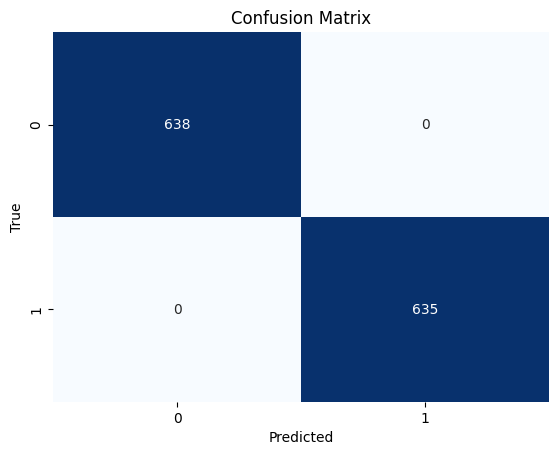

In [73]:
# Example usage
def main_training(train=True):
    # Load data
    _,_,_,_,train_loader, test_loader = get_train_test_loader()  # Assuming your main() function loads data and returns DataLoaders

    # Model parameters
    input_dims = [19, 500, 500, 500, 500, 800]  # Number of features for each modality
    embed_dim = 64  # Common embedding dimension
    num_heads = 4  # Number of attention heads
    num_layers = 1  # Number of layers in the transformer encoders

    # Initialize model, optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MultimodalModel(input_dims, embed_dim, num_heads, num_layers)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Train the model
    num_epochs = 30
    if train:
        train_model_with_contrastive_loss(model, train_loader, optimizer, num_epochs, device)
        metrics = test_model(model, train_loader, device)

    return model

model = main_training()

Test Metrics:
Accuracy: 0.8401
AUC: 0.9314
F1 Score: 0.8350
Precision: 0.8716
Recall: 0.8012
Specificity: 0.8797
MCC: 0.6827
AUPRC: 0.9285


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_28104\228421755.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded v

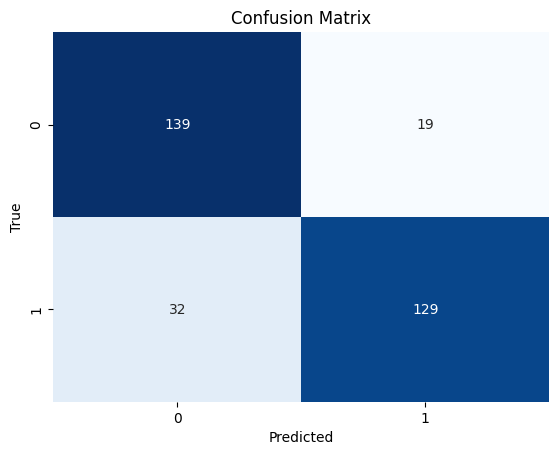

In [74]:
# save the model
torch.save(model.state_dict(), 'SA_CA_model.pth')

# load data
_,_,_,_,train_loader, test_loader = get_train_test_loader()

# load the model
model = main_training(train=False)
model.load_state_dict(torch.load('SA_CA_model.pth'))

# Evaluate the loaded model
metrics = test_model(model, test_loader)